### Loading data

In [30]:
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet


In [69]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import os
import numpy as np
import pandas as pd
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import itertools
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, plot_roc_curve, auc, RocCurveDisplay, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [32]:
df_train = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet").groupby('customer_ID').tail(4)
df_test = pd.read_parquet("/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet").groupby('customer_ID').tail(4)
train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")

In [33]:
df_train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
9,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-12-04,0.868580,0,0.001930,1.007504,0.001772,0.100470,0.0,0.006073,...,-1,-1,-1,0,0,0.0,NaN,0,0.004753,0
10,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-01-11,0.909811,0,0.002829,1.004798,0.008175,0.098882,0.0,0.003238,...,-1,-1,-1,0,0,0.0,NaN,0,0.003004,0
11,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-02-21,0.937349,0,0.019837,1.008307,0.000607,0.102985,0.0,0.007454,...,-1,-1,-1,0,0,0.0,NaN,0,0.006346,0
12,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,...,-1,-1,-1,0,0,0.0,NaN,0,0.002970,0
22,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-12-29,0.861109,10,0.006711,0.819772,0.007966,0.139138,0.0,0.005235,...,-1,-1,-1,0,0,0.0,NaN,0,0.003133,0


### EDA

In [34]:
df_train.shape, df_test.shape, train_labels.shape

((1802318, 190), (3656852, 190), (458913, 2))

In [35]:
df_train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1802318 entries, 9 to 5531450
Data columns (total 190 columns):
 #    Column       Non-Null Count    Dtype  
---   ------       --------------    -----  
 0    customer_ID  1802318 non-null  object 
 1    S_2          1802318 non-null  object 
 2    P_2          1788975 non-null  float32
 3    D_39         1802318 non-null  int16  
 4    B_1          1802318 non-null  float32
 5    B_2          1801953 non-null  float32
 6    R_1          1802318 non-null  float32
 7    S_3          1474135 non-null  float32
 8    D_41         1801953 non-null  float32
 9    B_3          1801953 non-null  float32
 10   D_42         244122 non-null   float32
 11   D_43         1272657 non-null  float32
 12   D_44         1802318 non-null  int8   
 13   B_4          1802318 non-null  int16  
 14   D_45         1801952 non-null  float32
 15   B_5          1802318 non-null  float32
 16   R_2          1802318 non-null  int8   
 17   D_46         1427983 non-

<AxesSubplot:xlabel='target', ylabel='count'>

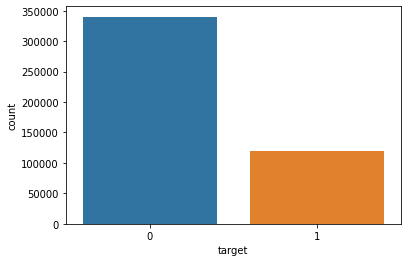

In [36]:
sns.countplot(x = 'target', data = train_labels)

In [37]:
def get_threshold_idx(threshold):
    return df_train.columns[(df_train.isna().sum()/len(df_train))>threshold/100]

# Drop cols nan more than 45%
drop_cols = get_threshold_idx(threshold=45)
df_train = df_train.drop(drop_cols, axis=1)
df_test = df_test.drop(drop_cols, axis=1)

In [38]:
num_cols = df_train.select_dtypes(include=[np.number])

# replace undefined numeric values by median
def replace_with_median(df):
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    return df

median_train = replace_with_median(df_train)
median_test = replace_with_median(df_test)
median_train = df_train.bfill(axis='rows').ffill(axis='rows')
median_test = df_test.bfill(axis='rows').ffill(axis='rows')
df_train = median_train
df_test = median_test

In [39]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
df_train = df_train.groupby('customer_ID').tail(1)
df_test = df_test.groupby('customer_ID').tail(1)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

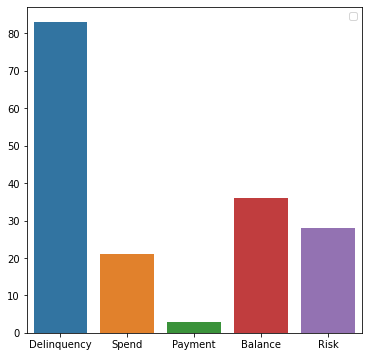

In [40]:
delinquency = df_train.columns[pd.Series(df_train.columns).str.startswith('D_')]
spend = df_train.columns[pd.Series(df_train.columns).str.startswith('S_')]
risk = df_train.columns[pd.Series(df_train.columns).str.startswith('R_')]
balance = df_train.columns[pd.Series(df_train.columns).str.startswith('B_')]
payment = df_train.columns[pd.Series(df_train.columns).str.startswith('P_')]

freq = {'Delinquency': len(delinquency), 'Spend': len(spend), 'Payment': len(payment), 'Balance': len(balance), 'Risk': len(risk),}
plt.figure(figsize=(6,6))
sns.barplot(x=list(freq.keys()), y=list(freq.values()));
plt.legend()

In [41]:
df_train.shape, df_test.shape, train_labels.shape

((458913, 173), (924621, 173), (458913, 2))

In [42]:
df_train = df_train.merge(train_labels, how='inner', on="customer_ID")
df_train.head()

,index,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,D_136,D_137,D_138,D_139,D_140,D_141,D_143,D_144,D_145,target
0,12,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,...,-1,-1,-1,0,0,0.0,0,0.002970,0,0
1,25,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2018-03-25,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,...,-1,-1,-1,0,0,0.0,0,0.003169,0,0
2,38,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-12,0.880875,0,0.004284,0.812649,0.006450,0.165247,0.0,...,-1,-1,-1,0,0,0.0,0,0.000834,0,0
3,51,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2018-03-29,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,...,-1,-1,-1,0,0,0.0,0,0.005560,0,0
4,64,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,2018-03-30,0.871900,0,0.007679,0.815746,0.001247,0.165247,0.0,...,-1,-1,-1,0,0,0.0,0,0.006944,0,0


In [43]:
df_train.columns[1]

'customer_ID'

In [44]:
df_test_copy = df_test.copy()
df_train = df_train.drop(['index','customer_ID', 'S_2'], axis=1)
df_test = df_test.drop(['index','customer_ID', 'S_2'], axis=1)

In [45]:
obj_cols = ['D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126']
df_train = pd.get_dummies(df_train, columns=obj_cols, drop_first=True)
df_test = pd.get_dummies(df_test, columns=obj_cols, drop_first=True)

In [46]:
df_train.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,D_117_0,D_117_2,D_117_3,D_117_4,D_117_5,D_117_6,D_117_7,D_120_0,D_120_1,D_126_2
0,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,0.091563,0,...,0,0,0,0,1,0,0,1,0,1
1,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,0.060646,0,...,1,0,0,0,0,0,0,1,0,1
2,0.880875,0,0.004284,0.812649,0.006450,0.165247,0.0,0.007196,0.091563,0,...,1,0,0,0,0,0,0,1,0,1
3,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,0.046104,0,...,0,0,0,0,0,0,1,1,0,1
4,0.871900,0,0.007679,0.815746,0.001247,0.165247,0.0,0.005528,0.044671,0,...,0,0,0,0,1,0,0,1,0,1


### Feature Extraction

In [47]:
def normalize(df):
    ''' z score normalization '''
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())/df[col].std() 
    return df

features = normalize(df_train.loc[:, df_test.columns])
df_test = normalize(df_test)
target = df_train['target']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=69)
features = X_train
target = y_train

## Amex Metric

In [49]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

### Train Model

In [50]:
def KNN(features, target):
    neighbor_id = KNeighborsClassifier(n_neighbors=3)
    neighbor_id.fit(features, target)
    return neighbor_id

In [51]:
def SVMLinear(features, target):
    svmLinear = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
    svmLinear.fit(Features, target)
    return svmLinear

In [52]:
def LGBM(feature, target):
    lgbm = LGBMClassifier(n_estimators=1150, learning_rate=0.03, reg_lambda=50, min_child_samples=2400, num_leaves=94,colsample_bytree=0.19,max_bins=517, random_state=1)
    lgbm.fit(features, target)
    return lgbm

In [53]:
def XGB(features, target):
    xgb = XGBClassifier(n_estimators=300, max_depth=7, learning_rate=0.1).fit(features, target)
    return xgb

In [54]:
# model = KNN(Features, target)
# model = SVMLinear(features, target)
# model = LGBM(features, target)
model = XGB(features, target)

In [ ]:
np.mean(cross_val_score(model, features, target, scoring='accuracy', cv=5))

In [57]:
y_pred = model.predict(features)
accuracy_score(target, y_pred)

0.9318918313156248

In [58]:
amex_metric_mod(target.values, y_pred)

0.7103983117544685

In [59]:
import joblib

joblib.dump(model, "model.joblib")

['model.joblib']

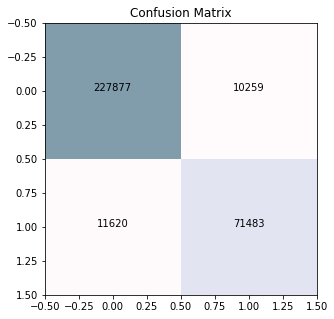

In [60]:
cm=confusion_matrix(target, y_pred)
plt.figure(figsize=(15,5))
plt.title("Confusion Matrix")
plt.imshow(cm, alpha=0.5, cmap='PuBu')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

In [61]:
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95    238136
           1       0.87      0.86      0.87     83103

    accuracy                           0.93    321239
   macro avg       0.91      0.91      0.91    321239
weighted avg       0.93      0.93      0.93    321239



In [72]:
df_test_copy['prediction'] = model.predict_proba(df_test)[:,1]
df_test_copy[['customer_ID','prediction']].to_csv("180199x-xgb.csv", index=False)